In [14]:
import numpy as np
import librosa
import tensorflow as tf
import glob

from myAudio import Audio


CHUNK_SIZE = 8192
SR = 44100


##########################
'''
batch_size = 2048
num_classes = 16            #분류할 사전의 크기 

learning_rate = 0.01    

output_dim = 3
layers = 3

N_MFCC = 16
sequence_length = 80 #layer
n_unique_labels = 3
'''
#################
n_mels = 40
n_frame = 500
window_size=1024
hop_size=512
num_classes = 40            #분류할 사전의 크기  
learning_rate = 0.01    
output_dim = 3
layers = 3

N_MFCC = 16
batch_size = 2048
sequence_length = 50 #layer
n_unique_labels = 3
###############
def makeHot(dataX, dataY, sequence_length):
    X_hot_list= []
    Y_hot_tmp = dataY[sequence_length-1:]

    for i in range(0, dataX.shape[0] - sequence_length+1):
        _x = dataX[i:i + sequence_length]
        #if i<10:
            #print(_x, "->", Y_hot_tmp[i])
        X_hot_list.append(_x)

    X_hot = np.array(X_hot_list[:])
    Y_hot= Y_hot_tmp.reshape((len(Y_hot_tmp),n_unique_labels))
    return X_hot[:], Y_hot[:]
def extractFeature(raw):
    dataX= mfcc4(raw,-1)
    #X_hot = makeHot(dataX,sequence_length = sequence_length)
    X_hot = dataX
    return X_hot[:]

def mfcc(raw, chunk_size=8192, sr=44100, n_mfcc=N_MFCC):
    mfcc = np.empty((sequence_length, 0))
    for i in range(0, len(raw), chunk_size):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc)
        mfcc = np.hstack((mfcc, mfcc_slice))
    print(mfcc.shape)
    return mfcc
def mfcc2(raw, chunk_size=8192, sr=SR, n_mfcc=N_MFCC):
    raw_mel = librosa.feature.melspectrogram(y=raw, sr=sr)
    s = librosa.power_to_db(raw_mel)
    mfcc = librosa.feature.mfcc(S=s, sr=sr, n_mfcc=n_mfcc)
    print(mfcc.shape)
    return mfcc

In [3]:
###########################################   Model   #########################################
X = tf.placeholder(tf.float32, [None, sequence_length,num_classes], name="X")
Y = tf.placeholder(tf.float32, [None, output_dim], name="Y")

keep_prob = tf.placeholder(tf.float32)

cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_classes, state_is_tuple=True)
#cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
cell = tf.contrib.rnn.MultiRNNCell([cell]*2, state_is_tuple= True)

BatchSize = tf.placeholder(tf.int32, [], name='BatchSize')
initial_state = cell.zero_state(BatchSize, tf.float32)
outputs, _states = tf.nn.dynamic_rnn(cell, X,initial_state=initial_state,dtype=tf.float32)

dense1 = tf.layers.dense(inputs=outputs[:,-1], units=sequence_length*output_dim, activation=tf.nn.relu)

dense2 = tf.layers.dense(inputs=dense1, units=sequence_length*output_dim, activation=tf.nn.relu)
dropout2 = tf.nn.dropout(dense1, keep_prob=keep_prob)

dense3 = tf.layers.dense(inputs=dense2, units=output_dim, activation=tf.nn.relu)

Y_pred= tf.layers.dense(inputs=dense3, units=output_dim)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Y_pred, labels=Y))
lr = tf.placeholder(tf.float32,shape=(), name='learning_rate')
train = tf.train.AdamOptimizer(lr).minimize(cost)


##################################################################################################


In [4]:
def load(files, sr=44100):
    [raw, sr] = librosa.load(files[0], sr=sr)
    for f in files[1:]:
        [array, sr] = librosa.load(f, sr=sr)
        raw = np.hstack((raw, array))
    print(raw.shape)
    return raw

In [5]:
import glob
uav_path = '../data/test_20sec/Unloaded/*.*'
loaded_path = '../data/test_20sec/Loaded/*.*'
none_path = '../data/test_20sec/Background/*.*'

uav_files = glob.glob(uav_path)
loaded_files = glob.glob(loaded_path)
none_files = glob.glob(none_path)
print(len(uav_files),'개\t', uav_files[0])
print(len(uav_files),'개\t', loaded_files[0])
print(len(none_files), '개\t',none_files[0])
uav_raw = load(uav_files)
loaded_raw = load(loaded_files)
none_raw = load(none_files)


1 개	 ../data/test_20sec/Unloaded\test_unloaded.wav
1 개	 ../data/test_20sec/Loaded\test_loaded.wav
3 개	 ../data/test_20sec/Background\test_background.wav
(1762047,)
(3530248,)
(11364138,)


In [6]:
#mfcc_none = mfcc(none_raw)
#mfcc_uav = mfcc(uav_raw)
#mfcc_loaded = mfcc(loaded_raw)

#mfcc_none = mfcc2(none_raw)
#mfcc_uav = mfcc2(uav_raw)
#mfcc_load = mfcc2(loaded_raw)

#y_none =np.zeros(mfcc_none.shape[1], dtype=int)
#y_uav = np.ones(mfcc_uav.shape[1], dtype=int)
#y_loaded = np.ones(mfcc_load.shape[1], dtype=int)*2

none_spec = librosa.feature.melspectrogram(y=none_raw, sr=SR,n_fft=window_size, hop_length=hop_size, power=2.0, n_mels=40)
uav_spec = librosa.feature.melspectrogram(y=uav_raw, sr=SR,n_fft=window_size, hop_length=hop_size, power=2.0, n_mels=40)
load_spec = librosa.feature.melspectrogram(y=loaded_raw, sr=SR,n_fft=window_size, hop_length=hop_size, power=2.0, n_mels=40)

y_none =np.zeros(none_spec.shape[1], dtype=int)
y_uav = np.ones(uav_spec.shape[1], dtype=int)
y_loaded = np.ones(load_spec.shape[1], dtype=int)*2

In [7]:
#X_mfcc = np.hstack((none_spec, uav_spec))
#X_mfcc = np.hstack((X_mfcc, load_spec))
#X_mfcc = X_mfcc.T

X_mfcc = np.hstack((none_spec, uav_spec))
X_mfcc = np.hstack((X_mfcc, load_spec))
X_mfcc = X_mfcc.T

y = np.hstack((y_none,  y_uav))
y = np.hstack((y,y_loaded))

#X = np.concatenate((mfcc_loaded, mfcc_uav, mfcc_none), axis=0)
#y = np.hstack((y_loaded, y_uav, y_none))
print(X_mfcc.shape, y.shape)


(32534, 40) (32534,)


In [8]:
n_unique_labels = 3
n_labels = y.shape[0]
y_encoded = np.zeros((n_labels, n_unique_labels))
y_encoded[np.arange(n_labels), y] = 1
print(y_encoded.shape)
#print(y_encoded[0], y_encoded[40000],y_encoded[100000])

(32534, 3)


In [9]:
dataX = X_mfcc
dataY = y_encoded
#print(y_encoded)
print(dataX.shape, dataY.shape)

#X_hot = np.array(dataX[:])
#Y_hot = np.array(dataY[:])
X_hot, Y_hot = makeHot( dataX, dataY, sequence_length)
print(X_hot.shape, Y_hot.shape)


(32534, 40) (32534, 3)
(32485, 50, 40) (32485, 3)


In [15]:
print(batch_size, num_classes)
print(learning_rate, sequence_length)
print(output_dim, layers)

2048 40
0.01 50
3 3


INFO:tensorflow:Restoring parameters from ../models/RNN/my_RNN_model_test_RNN
(32485,) (32485,)
F-Score: 0.846
Accuracy:  0.8460828074495921
             precision    recall  f1-score   support

          0       0.83      0.99      0.90     22147
          1       0.89      0.30      0.45      3442
          2       0.94      0.65      0.77      6896

avg / total       0.86      0.85      0.83     32485

[[21935   128    84]
 [ 2208  1042   192]
 [ 2388     0  4508]]


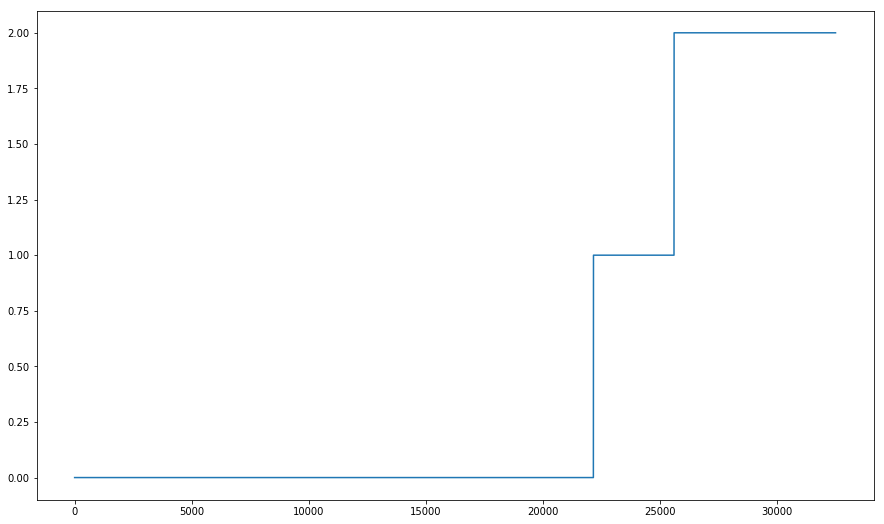

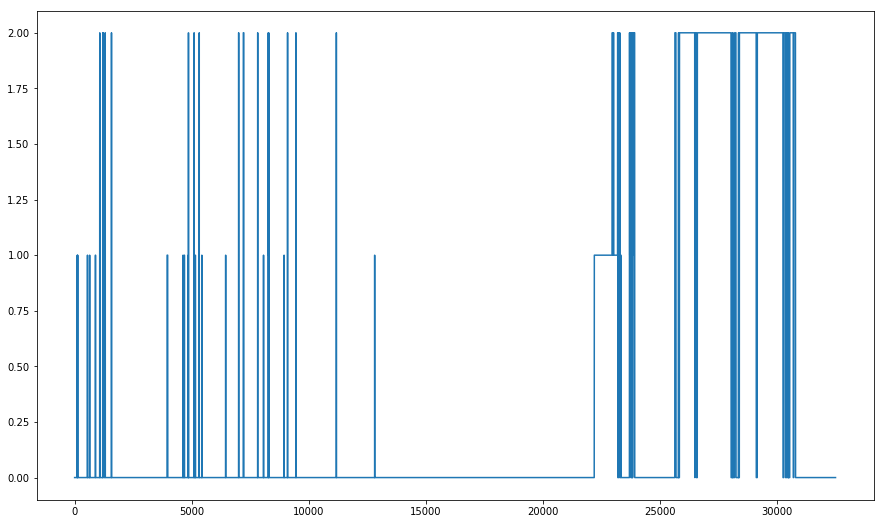

In [16]:
sess = tf.Session()
saver = tf.train.Saver()
model_path = '../models/RNN/my_RNN_model_test_RNN'
saver.restore(sess, model_path)

y_pred = sess.run(tf.argmax(Y_pred,1), feed_dict={
    X: X_hot, BatchSize:len(X_hot), keep_prob:1.0})
y_true = sess.run(tf.argmax(Y_hot,1))
print(y_pred.shape, y_true.shape)

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
print("Accuracy: ", accuracy_score(y_true, y_pred))

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_true)

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_pred)